In [60]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

## Initial Cox Regression

In [53]:
interval_and_weather_merged = pd.read_csv('./interval_and_weather_merged.csv')
interval_and_weather_merged_reyna = pd.read_csv('./reyna_interval_and_weather_merge.csv')
df_list = [interval_and_weather_merged, interval_and_weather_merged_reyna ]
print(interval_and_weather_merged.shape)
print(interval_and_weather_merged_reyna.shape)
interval_and_weather_merged = pd.concat(df_list)

interval_and_weather_merged

(298, 21)
(46, 21)


,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_insect,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,0,0 days 11:41:43,0 days 11:44:13,150000000000,Insecta,Insecta,07-28-2022 i10 Zinnia,2022-07-28 11:41:43,2022-07-28 12:00:00,1,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
1,1,0 days 11:44:43,0 days 12:04:13,1170000000000,Insecta,Syrphinae,07-28-2022 i10 Zinnia,2022-07-28 11:44:43,2022-07-28 12:00:00,0,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
2,2,0 days 13:43:07,0 days 13:54:07,660000000000,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,2022-07-28 14:00:00,0,...,25.0,79.0,0.0,NaN,271.0,8.3,NaN,1013.0,NaN,3.0
3,3,0 days 12:57:16,0 days 12:59:20,124000000000,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
4,4,0 days 13:00:22,0 days 13:00:53,31000000000,Apis mellifera,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:00:22,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,43,0 days 12:17:54,0 days 13:09:55,3121000000000,Bombus impatiens,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 12:17:54,2022-08-25 12:00:00,0,...,17.0,100.0,0.0,NaN,0.0,0.0,NaN,1019.0,NaN,1.0
42,41,0 days 12:38:26,0 days 12:39:56,90000000000,apoidea,Poanes zabulon,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:38:26,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
43,42,0 days 12:40:56,0 days 13:54:27,4411000000000,Poanes zabulon,Macroglossum stellatarum,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:40:56,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
44,44,0 days 13:10:55,0 days 13:20:55,600000000000,NaN,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 13:10:55,2022-08-25 13:00:00,1,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0


In [54]:
# Data Cleanup including Removing American Aster
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['sheet_title'] != '10-14-2022 i11 American Aster') & (interval_and_weather_merged['sheet_title'] != '10-14-2022 i8 American Aster')]

# Interval column is in nanoseconds
interval_cut_off = 1*60*1000*1000000
df_less_than_interval = interval_and_weather_merged[(interval_and_weather_merged['interval'] < interval_cut_off) & (interval_and_weather_merged['same_insect'] == True)]

df_minus_short_interval_same_insect = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= interval_cut_off) | (interval_and_weather_merged['same_insect'] == False)]
df_minus_short_interval_same_insect

,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_insect,...,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,0,0 days 11:41:43,0 days 11:44:13,150000000000,Insecta,Insecta,07-28-2022 i10 Zinnia,2022-07-28 11:41:43,2022-07-28 12:00:00,1,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
1,1,0 days 11:44:43,0 days 12:04:13,1170000000000,Insecta,Syrphinae,07-28-2022 i10 Zinnia,2022-07-28 11:44:43,2022-07-28 12:00:00,0,...,23.0,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0
2,2,0 days 13:43:07,0 days 13:54:07,660000000000,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,2022-07-28 14:00:00,0,...,25.0,79.0,0.0,NaN,271.0,8.3,NaN,1013.0,NaN,3.0
3,3,0 days 12:57:16,0 days 12:59:20,124000000000,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
5,5,0 days 13:01:55,0 days 13:03:28,93000000000,Augochlorini,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:01:55,2022-08-04 13:00:00,1,...,25.0,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,43,0 days 12:17:54,0 days 13:09:55,3121000000000,Bombus impatiens,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 12:17:54,2022-08-25 12:00:00,0,...,17.0,100.0,0.0,NaN,0.0,0.0,NaN,1019.0,NaN,1.0
42,41,0 days 12:38:26,0 days 12:39:56,90000000000,apoidea,Poanes zabulon,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:38:26,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
43,42,0 days 12:40:56,0 days 13:54:27,4411000000000,Poanes zabulon,Macroglossum stellatarum,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:40:56,2022-08-25 13:00:00,0,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0
44,44,0 days 13:10:55,0 days 13:20:55,600000000000,NaN,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 13:10:55,2022-08-25 13:00:00,1,...,21.0,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0


In [ ]:
def run_cox_regression_on_all_data(interval_and_weather_merged):
  # JCB: List of ones to represent that all intervals have completed
  status = np.ones(interval_and_weather_merged.shape[0])

  mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                  interval_and_weather_merged, status=status, ties="efron")
  rslt = mod.fit()
  print(rslt.summary())
  
run_cox_regression_on_all_data(interval_and_weather_merged)

status = np.ones(interval_and_weather_merged.shape[0])
interval_and_weather_merged['status'] = status
# 

In [ ]:
rossi = load_rossi()

# same_insect + temp + wspd + dwpt + coco
cph = CoxPHFitter()

trimmed_df = interval_and_weather_merged[['interval','status', 'same_insect' , 'temp' , 'wspd' , 'dwpt' , 'coco']].copy()
trimmed_df = trimmed_df.reset_index(drop=True)
cph.fit(trimmed_df, 'interval', 'status')
# cph.print_summary(model="untransformed variables", decimals=3)
cph.check_assumptions(trimmed_df, p_value_threshold=0.05, show_plots=True)
# trimmed_df


In [ ]:
cph.fit(rossi, 'week', 'arrest')
cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)
# rossi

## Notes from Tom
Qualitative 

In [ ]:
def run_bin_temp_analysis(df, binned_column, number_of_bins):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])

    # Print out the DataFrame grouped by temperature group
    for name, group in interval_and_weather_merged.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_temp_range = f"{name}: {group['temp'].min()} - {group['temp'].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

run_bin_temp_analysis(interval_and_weather_merged, 'temp', 3)

In [ ]:
# Summary Stats about Reyna's Data
print(interval_and_weather_merged_reyna.temp.quantile([0.25,0.5,0.75]))

print(interval_and_weather_merged.temp.quantile([0.25,0.5,0.75]))

### New binning analysis function but for time

In [ ]:
def run_bin_time_analysis(interval_and_weather_merged, binned_column, number_of_bins):

    interval_and_weather_merged[binned_column] = pd.to_datetime(interval_and_weather_merged[binned_column])

    # Find the range of the `time` column
    time_min = interval_and_weather_merged[binned_column].min().floor('H')
    time_max = interval_and_weather_merged[binned_column].max().floor('H')

    print(f"Photo data {binned_column} range")
    print(time_min)
    print(time_max)

    # Calculate the range of each group based on the total range of `time`
    group_range = (time_max - time_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the time group for each row
    interval_and_weather_merged['binned_group'] = pd.cut(interval_and_weather_merged[binned_column], bins=[time_min, time_min+group_range, time_min+2*group_range, time_max], labels=['Low', 'Medium', 'High'])

    # Print out the DataFrame grouped by time group
    for name, group in interval_and_weather_merged.groupby('time_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        status = np.ones(len(group))

        mod = smf.phreg("interval ~ same_insect + temp + wspd + dwpt + coco",
                        group, status=status, ties="efron")
        rslt = mod.fit()
        print(rslt.summary())
# df_minus_short_interval_same_insect

run_bin_time_analysis(df_minus_short_interval_same_insect, 'timestamp_pd_rounded', 3)

## Pycox Expirementation


In [55]:
# Add status to the dataframe
interval_and_weather_merged = interval_and_weather_merged.assign(status=1)
# interval_and_weather_merged.head()

In [34]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']
df_train = interval_and_weather_merged[cols_input]


# Step 2: Split data into training, validation, and test sets
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,interval,status,temp,dwpt,wspd,coco,same_insect
0,150000000000,1,23.0,23.0,7.2,3.0,1
1,1170000000000,1,23.0,23.0,7.2,3.0,0
2,660000000000,1,29.0,25.0,8.3,3.0,0
3,124000000000,1,28.0,25.0,7.0,1.0,1
4,31000000000,1,28.0,25.0,7.0,1.0,1


In [47]:
cols_standardize = []
cols_leave = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_insect']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_val

array([[1.850e+11, 1.000e+00, 1.500e+01, 4.100e+00, 1.300e+01, 1.000e+00,
        1.000e+00],
       [8.900e+10, 1.000e+00, 2.000e+01, 1.010e+01, 1.500e+01, 1.000e+00,
        1.000e+00],
       [3.540e+11, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        1.000e+00],
       [1.560e+12, 1.000e+00, 2.400e+01, 1.700e+01, 1.120e+01, 3.000e+00,
        0.000e+00],
       [4.000e+09, 1.000e+00, 2.200e+01, 1.610e+01, 1.300e+01, 3.000e+00,
        0.000e+00],
       [4.860e+11, 1.000e+00, 1.400e+01, 1.000e+01, 7.000e-01, 3.000e+00,
        1.000e+00],
       [1.360e+11, 1.000e+00, 1.400e+01, 1.000e+01, 7.000e-01, 3.000e+00,
        1.000e+00],
       [7.800e+10, 1.000e+00, 2.500e+01, 1.700e+01, 1.300e+01, 3.000e+00,
        1.000e+00],
       [3.054e+12, 1.000e+00, 1.800e+01, 1.010e+01, 1.100e+01, 1.000e+00,
        1.000e+00],
       [8.390e+11, 1.000e+00, 2.100e+01, 2.100e+01, 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.300e+10, 1.000e+00, 2.300e+01, 1.610e+01, 1.120e+0

In [45]:
num_durations = 100

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['interval'].values, df['status'].values)

# I do not understand the output of the labtrans.fit_transform() function
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)
print(y_train)

(array([ 2, 10,  6,  1,  1,  1,  1,  9,  8,  6,  5, 22,  3, 17, 14,  1,  1,
        1,  2,  8, 12, 31,  5,  1,  1,  1,  1,  2,  1,  5,  1,  1,  3,  2,
        1,  7,  3,  1,  4,  4,  7,  1,  1,  6,  1,  2,  1,  1,  3,  1,  1,
        1, 22,  2,  1,  1,  1,  2,  2,  1,  1,  2,  1, 22,  3,  7, 22, 15,
        7, 17, 13, 20,  3,  1,  2,  6,  5,  6, 12,  6,  1, 16,  7, 20, 17,
        3, 35,  3,  1,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1,  2,  1,  2,
        1,  5,  1,  3,  7,  1,  3,  4,  1,  4,  1, 27,  7, 21,  1,  1,  2,
        2,  3,  5,  1,  2,  1,  2,  1,  1,  2,  3,  1,  5,  1,  4,  8,  2,
        3,  3, 15,  6, 12, 11,  1,  1,  2,  4,  1,  1, 12, 12, 17,  1,  2,
        4, 99,  2,  1, 20,  4,  6,  1, 15,  6, 12,  8,  6,  2,  1, 14,  6,
       25,  1]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       

In [48]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


0:	[0s / 0s],		train_loss: 6.2483,	val_loss: 7.3574
1:	[0s / 0s],		train_loss: 5.1422,	val_loss: 4.9684
2:	[0s / 0s],		train_loss: 4.4121,	val_loss: 4.0074
3:	[0s / 0s],		train_loss: 3.8399,	val_loss: 3.4875
4:	[0s / 0s],		train_loss: 3.4988,	val_loss: 3.1325
5:	[0s / 0s],		train_loss: 3.1266,	val_loss: 2.8960
6:	[0s / 0s],		train_loss: 2.8202,	val_loss: 2.7454
7:	[0s / 0s],		train_loss: 2.7105,	val_loss: 2.6378
8:	[0s / 0s],		train_loss: 2.5330,	val_loss: 2.5519
9:	[0s / 0s],		train_loss: 2.3346,	val_loss: 2.4838
10:	[0s / 0s],		train_loss: 2.2777,	val_loss: 2.4228
11:	[0s / 0s],		train_loss: 2.1862,	val_loss: 2.3719
12:	[0s / 0s],		train_loss: 2.0938,	val_loss: 2.3243
13:	[0s / 0s],		train_loss: 2.0143,	val_loss: 2.2782
14:	[0s / 0s],		train_loss: 1.9572,	val_loss: 2.2348
15:	[0s / 0s],		train_loss: 1.8781,	val_loss: 2.1889
16:	[0s / 0s],		train_loss: 1.8777,	val_loss: 2.1451
17:	[0s / 0s],		train_loss: 1.7895,	val_loss: 2.0995
18:	[0s / 0s],		train_loss: 1.7211,	val_loss: 2.0593
19:

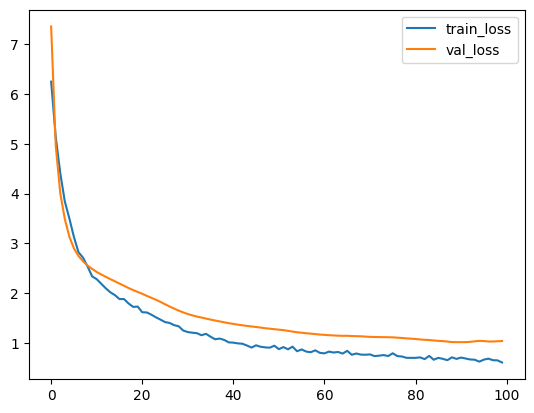

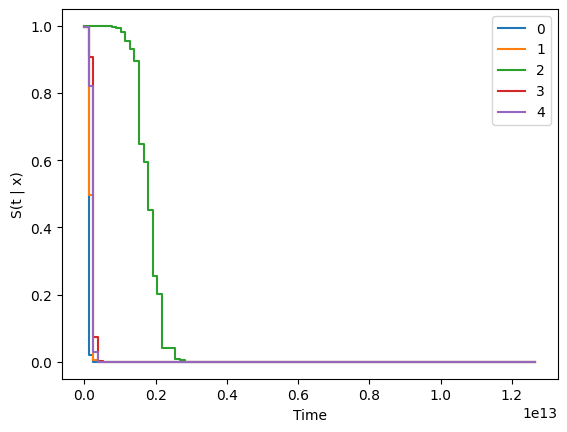

In [51]:
_ = log.plot()
log.to_pandas().val_loss.min()
model.score_in_batches(val)
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
# S(t | x) is the survival curve
# Assumption is this is the discrete data. The events they are fitting on is coming in discrete windows
# Our photo data has a consistent discretization grid in that we are checking in on the process every 30 seconds
# 
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

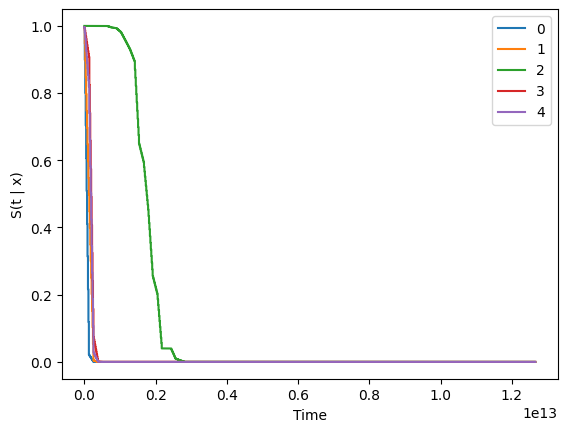

In [52]:
surv = model.interpolate(10).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

### Old Attempt for training

In [23]:
# Extract input features and output label
x = interval_and_weather_merged[['temp', 'dwpt', 'wspd', 'coco', 'same_insect']]
y = interval_and_weather_merged[['interval', 'status']]

x = x.astype({'same_insect': 'float64'})
y = y.astype({'interval': 'float64', 'status': 'float64'})

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(y_train.head())

# TODO: Skipping the step with the DataFrameMapper function



# Transform output label
get_target = lambda df: (df['interval'].values, df['status'].values)
labtrans = LogisticHazard.label_transform(cuts=100)
y_train_trans = labtrans.fit_transform(*get_target(y_train))

y_train_trans = (np.array(y_train_trans[0], dtype='float64'), np.array(y_train_trans[1], dtype='float64'))



# labtrans.cuts
print(type(labtrans.transform(*get_target(y_val))))
print(y_train_trans[1].dtype)
# print(x_train.values.dtype)

         interval  status
262  2.062000e+12     1.0
281  1.410000e+11     1.0
278  4.260000e+11     1.0
73   7.600000e+10     1.0
25   1.400000e+10     1.0
<class 'tuple'>
float64


In [29]:

# Define model architecture
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

# Transform output label to `float64` for validation set
y_val_trans = labtrans.transform(*get_target(y_val))
y_val_trans = tuple(np.array(x, dtype='float64') for x in y_val_trans)
print(y_val_trans[0].dtype)
print(y_val_trans[1].dtype)
print(y_train_trans[0].dtype)
print(y_train_trans[1].dtype)
print(x_train.values.dtype)
print(x_val.values.dtype)
print(x_train.isna().sum())
print(y_train_trans.isna().sum())


# Train model
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]
# Checking types 
log = model.fit(x_train.values, y_train_trans, batch_size, epochs, callbacks, val_data=(x_val.values, y_val_trans))


float64
float64
float64
float64
float64
float64
temp           0
dwpt           0
wspd           0
coco           0
same_insect    0
dtype: int64


AttributeError: 'tuple' object has no attribute 'isna'

In [32]:
print("x_train shape:", x_train.values.shape)
print("y_train_trans[0] shape:", y_train_trans[0].shape)
print("y_train_trans[1] shape:", y_train_trans[1].shape)
print("x_val shape:", x_val.values.shape)
print("y_val_trans[0] shape:", y_val_trans[0].shape)
print("y_val_trans[1] shape:", y_val_trans[1].shape)

x_train shape: (233, 5)
y_train_trans[0] shape: (233,)
y_train_trans[1] shape: (233,)
x_val shape: (59, 5)
y_val_trans[0] shape: (59,)
y_val_trans[1] shape: (59,)


In [62]:
# Attempt at logistic regression
# TODO normalize the variables and make sure they are all the same type like what you did for pyCox
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(stacked_predictor_df, stacked_binary_response_df)
# LR.predict(X.iloc[460:,:])
# round(LR.score(X,y), 4)

ValueError: could not convert string to float: '0 days 11:41:43'